In [1]:
%reload_ext autoreload
%autoreload 2

import pandas as pd
from utils.path import WildcardPath
from utils.enums import ToolEnum, FeatureEnum as FE, FeatureDirectionEnum as FDE, FeatureTypeEnum as FTE
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np

import alignment.ensemble
import alignment.dataset
import utils.plots
from features.pairwise import _CUSTOM_METRICS
from utils.dataloading import load_balibase_results

In [2]:
_, test_feats, *_ = load_balibase_results(
    ["treebase_test_small_v2"], with_reference=False, benchmarking_scores=False
)
# test_feats[["n_sequences", "max_sequence_length"]].isna().mean(axis=0)
test_feats.isna().mean(axis=0).sort_values(ascending=False)

unaligned: (10, 87)
aligned: (70, 195)
confusion: (70, 18)


max_pythia_score            0.028571
mean_pythia_score           0.028571
min_pythia_score            0.028571
std_pythia_score            0.028571
median_pythia_score         0.028571
                              ...   
mean_kmer_similarity_5      0.000000
median_kmer_similarity_5    0.000000
std_kmer_similarity_5       0.000000
min_kmer_similarity_10      0.000000
max_kmer_similarity_10      0.000000
Length: 195, dtype: float64

In [3]:
DATA_DIR = WildcardPath("/hits/fast/cme/bodynems/data/")
RESULT_DIR = WildcardPath("/hits/fast/cme/bodynems/MSA_difficulty/results")

run_suffix = ""
# run_suffix = "_muscle5"
# run_suffix = "_reduced"

BENCHMARKS = ["treebase"]
# BENCHMARKS = ["balibase3/RV11", "balibase3/RV12"]

OUTPUT_DIR = DATA_DIR / "output" / "{benchmark}"
TOOL_DIR = OUTPUT_DIR / "{dataset}" / "{tool}"

DATASETS = OUTPUT_DIR.format(benchmark=BENCHMARKS[0]).listdir(dirs_only=True)
_file_suffix_map = {"": "_multi", "_muscle5": "_muscle5", "_reduced": "_reduced"}
file_suffix = _file_suffix_map[run_suffix]

benchmark_mapping = dict(zip(BENCHMARKS, ["RV11 (hard)", "RV12 (easy)"]))

In [4]:
id_cols = ["benchmark", "dataset", "tool"]
(
    unaligned_features,
    aligned_features,
    aligned_cols,
    reference_features,
    confusion_features,
    _,
    _,
) = load_balibase_results(BENCHMARKS, with_reference=False, benchmarking_scores=False)
aligned_cols = aligned_cols.to_list()

unaligned: (799, 87)
aligned: (5593, 195)
confusion: (5593, 18)


In [5]:
unaligned_features[["data_type", "n_sequences", "max_sequence_length"]].groupby(
    "data_type"
).describe().T

data_type                           AA          DNA
n_sequences         count   399.000000   400.000000
                    mean     64.596491    82.455000
                    std      50.352677    41.869627
                    min       6.000000     7.000000
                    25%      27.500000    49.000000
                    50%      51.000000    73.000000
                    75%      87.500000   112.000000
                    max     233.000000   185.000000
max_sequence_length count   399.000000   400.000000
                    mean   1366.112782  2898.350000
                    std    2194.225060  1977.814232
                    min      34.000000   253.000000
                    25%     279.000000  1317.750000
                    50%     507.000000  2396.500000
                    75%     885.000000  4045.500000
                    max    9975.000000  8157.000000

In [5]:
aux_cols = ["data_type"]
feat = FE.HOMOLOGY_POS_DIST

candidates = [
    FE.HOMOLOGY_POS_DIST,
    # FE.HOMOLOGY_SEQ_DIST,
    # FE.SSP_DIST,
    FE.CONFUSION_ENTROPY,
    # FE.CONFUSION_DISPLACEMENT,
    # FE.CONFUSION_SET,
    FE.DISPERSION,
    FE.COLUMN_CONFIDENCE,
    FE.PERC_HASH_HAMMING,
]
candidate_names = [
    "mean_homology_pos_dist",
    # "mean_homology_seq_dist",
    # "mean_symmetrized_sp_dist",
    "mean_confusion_entropy",
    # "mean_confusion_displacement",
    # "mean_confusion_set",
    "dispersion",
    "column_confidence",
    "mean_perc_hash_hamming_dist_16bit",
]
pretty_names = [enum.pretty for enum in candidates]

candidate_df = aligned_features[id_cols + aux_cols + candidate_names].copy()
candidate_df.columns = candidate_df.columns.str.lstrip("mean_")
candidate_names = [name.lstrip("mean_") for name in candidate_names]
candidate_df.loc[:, str(FE.COLUMN_CONFIDENCE)] = (
    1 - candidate_df[str(FE.COLUMN_CONFIDENCE)].copy()
)
candidate_df = candidate_df[candidate_df.tool == "all"]
# candidate_df.columns = id_cols + pretty_names

In [7]:
candidate_names = [
    "mean_homology_pos_dist",
    # "mean_homology_seq_dist",
    # "mean_symmetrized_sp_dist",
    "mean_confusion_entropy",
    # "mean_confusion_displacement",
    # "mean_confusion_set",
    "dispersion",
    "column_confidence",
    "mean_perc_hash_hamming_dist_16bit",
]
# print(candidate_names)
identity_cols = [
    "min_intrinsic_column_identity",
    "max_intrinsic_column_identity",
    "mean_intrinsic_column_identity",
    "median_intrinsic_column_identity",
    "std_intrinsic_column_identity",
]
aligned_features.loc[:, candidate_names + identity_cols].corr()[identity_cols].T

,mean_homology_pos_dist,mean_confusion_entropy,dispersion,column_confidence,mean_perc_hash_hamming_dist_16bit,min_intrinsic_column_identity,max_intrinsic_column_identity,mean_intrinsic_column_identity,median_intrinsic_column_identity,std_intrinsic_column_identity
min_intrinsic_column_identity,-0.140015,-0.101851,0.050609,-0.168125,-0.026884,1.000000,0.968977,0.988696,0.986755,0.186629
max_intrinsic_column_identity,0.037235,0.061235,0.220002,-0.356998,0.159172,0.968977,1.000000,0.993937,0.993583,0.417868
mean_intrinsic_column_identity,-0.041458,-0.013106,0.146309,-0.278053,0.078106,0.988696,0.993937,1.000000,0.999642,0.322528
median_intrinsic_column_identity,-0.039704,-0.012102,0.147995,-0.280829,0.080307,0.986755,0.993583,0.999642,1.000000,0.328025
std_intrinsic_column_identity,0.662598,0.634721,0.701727,-0.797436,0.752822,0.186629,0.417868,0.322528,0.328025,1.000000


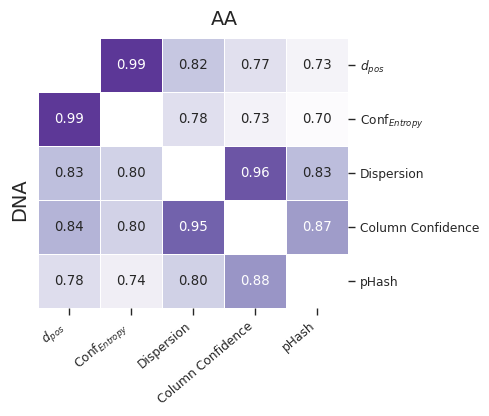

In [7]:
plot_df = candidate_df.copy()
plot_df.columns = id_cols + aux_cols + pretty_names
# temp = plot_df.loc[:, [pretty_names[0], pretty_names[2]]]
# temp = 1 / (np.array([1, 2]) / temp).sum(axis=1)
# plot_df["pHash"] = temp
corr_df_dna = plot_df[plot_df["data_type"] == "DNA"].corr(numeric_only=True)
corr_df_aa = plot_df[plot_df["data_type"] == "AA"].corr(numeric_only=True)
corr_df = np.tril(corr_df_dna) + np.triu(corr_df_aa)
corr_df[corr_df > 1] = None
# corr_df = corr_df.clip(0,1)
corr_df = pd.DataFrame(corr_df, index=corr_df_aa.index, columns=corr_df_aa.columns)
# corr_df[:] = np.tril(corr_df, k=-1)
# corr_df[:] = corr_df *  (1-np.eye(len(corr_df)))
# corr_df[corr_df == 0] = None
# corr_df = corr_df.iloc[1:,:-1]
fig = plt.figure(figsize=(4, 3.5))
fig.tight_layout()
ax = sn.heatmap(
    corr_df,
    annot=True,
    fmt=".2f",
    vmin=0.7,
    vmax=1.05,
    cmap=sn.color_palette("Purples", as_cmap=True),
    # cmap=sn.dark_palette("#69d", reverse=False, as_cmap=True),
    cbar=False,
    linewidths=0.6,
)
ax.patch.set_facecolor("white")
ax.grid(visible=False)
plt.xticks(rotation=40, ha="right")
plt.ylabel("DNA", fontsize=14)
plt.xlabel("AA", fontsize=14)
ax.xaxis.set_label_coords(0.6, 1.05)
ax.yaxis.set_label_coords(-0.03, 0.4)
plt.gca().tick_params(
    axis="both", right=True, bottom=True, labelleft=False, labelright=True
)
plt.yticks(rotation=0)
ax.xaxis.set_label_position("top")

# plt.savefig(RESULT_DIR / "treebase" / "treebase_correlations.svg", bbox_inches="tight")

In [ ]:
def violin_subplot(plot_df, val_name, ax, legend: bool):
    colors = sn.color_palette("hls", 10)
    colors = [colors[0], colors[6]]
    sn.violinplot(
        plot_df,
        x="method",
        y=val_name,
        split=True,
        hue="data_type",
        bw_adjust=0.25,
        bw_method="scott",
        width=0.9,
        saturation=1,
        inner="quart",
        palette=colors,
        common_norm=True,
        density_norm="width",
        gap=0.1,
        cut=0,
        ax=ax,
        legend=legend,
        zorder=1,
        # alpha=1.2
    )
    xmin, xmax = (-0.75, 4.5)
    div_1 = 1.5
    div_2 = 3.5
    ax.axvspan(xmin=xmin, xmax=div_1, facecolor="tab:blue", alpha=0.05, zorder=0.9)
    ax.axvspan(xmin=div_1, xmax=div_2, facecolor="tab:olive", alpha=0.1, zorder=0.9)
    ax.axvspan(xmin=div_2, xmax=xmax, facecolor="tab:purple", alpha=0.1, zorder=0.9)

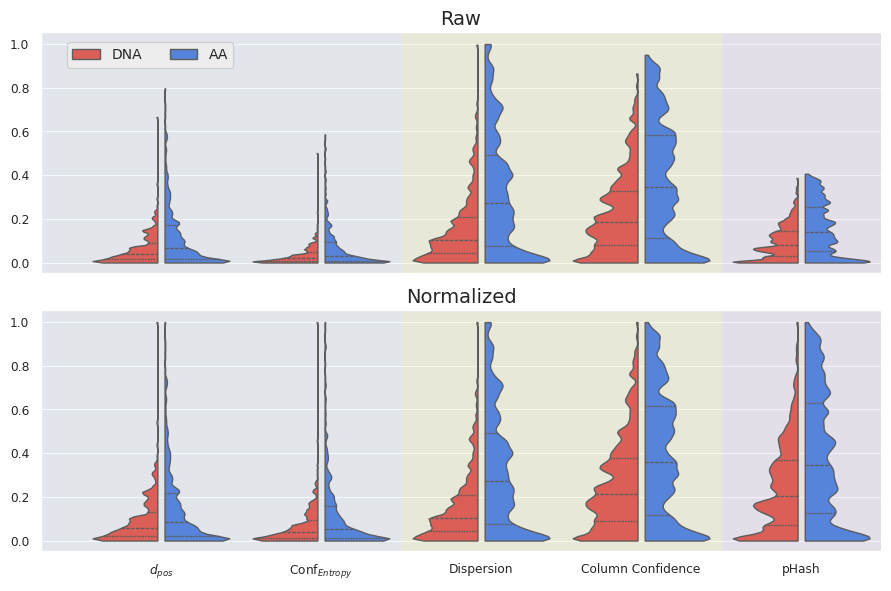

In [9]:
plot_df = candidate_df.copy()
plot_df.columns = id_cols + aux_cols + pretty_names

# test_methods = [FE.HOMOLOGY_POS_DIST.pretty, FE.DISPERSION.pretty]
# temp = plot_df.loc[:, test_methods].to_numpy() + 1e-8
# temp = 2 / (temp**-1).sum(axis=1)
# plot_df["pHash"] = temp.astype(float)

plot_df_std = plot_df.copy()
type_mask = plot_df_std.data_type == "AA"
plot_df_std.loc[type_mask, pretty_names] = plot_df_std.loc[
    type_mask, pretty_names
] / plot_df_std.loc[type_mask, pretty_names].max(axis=0)
plot_df_std.loc[~type_mask, pretty_names] = plot_df_std.loc[
    ~type_mask, pretty_names
] / plot_df_std.loc[~type_mask, pretty_names].max(axis=0)

val_name = ""
plot_df = pd.melt(plot_df, id_cols + aux_cols, pretty_names, "method", val_name)
val_name_std = ""
plot_df_std = pd.melt(
    plot_df_std, id_cols + aux_cols, pretty_names, "method", val_name_std
)
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(9, 6), layout="tight")
# fig.tight_layout()
# sn.stripplot(plot_df, x="method", y="value", hue="data_type", dodge=True, alpha=0.3)
violin_subplot(plot_df, val_name, axes[0], legend=True)
violin_subplot(plot_df_std, val_name_std, axes[1], legend=False)

axes[0].set_title("Raw", fontsize=14)
axes[1].set_title("Normalized", fontsize=14)

xmin, xmax = (-0.75, 4.5)
plt.xlim(xmin, xmax)
plt.xlabel("")
# plt.legend().set_title("")
sn.move_legend(
    axes[0],
    "upper center",
    ncols=2,
    bbox_to_anchor=(0.13, 0.99),
    title="",
    framealpha=1,
    prop=dict(size=10),
)

# fig.savefig(
#     RESULT_DIR / "treebase" / "treebase_norm_distributions.svg", bbox_inches="tight"
# )

unaligned: (961, 87)
aligned: (6727, 205)
confusion: (6727, 18)
                        mean_homology_pos_dist  mean_pythia_score
mean_homology_pos_dist                1.000000          -0.236208
mean_pythia_score                    -0.236208           1.000000


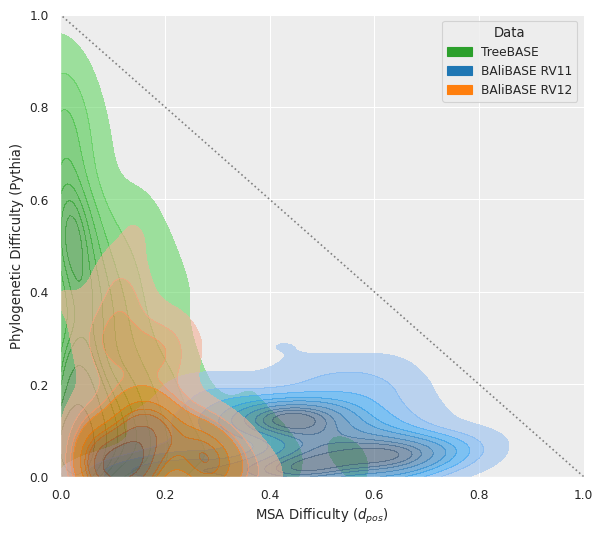

In [146]:
# Pythia vs MSA Difficulty
all_sources = np.array(["treebase", "balibase3/RV11", "balibase3/RV12"])
texts = np.array(["TreeBASE", "BAliBASE RV11", "BAliBASE RV12"])
colors = np.array(sn.color_palette(n_colors=3))
plot_order = [0, 1, 2]
color_order = [2, 0, 1]
legend_order = [0, 1, 2]
_, plot_features, *_ = load_balibase_results(all_sources, with_reference=False)
plot_features = plot_features[plot_features.tool == "all"]
x = "mean_" + FE.HOMOLOGY_POS_DIST
y = "mean_" + FE.PYTHIA_SCORE
print(aligned_features[[x, y]].corr())

fig = plt.figure(figsize=(6.75, 6))
fig.tight_layout()
ax = sn.kdeplot(
    plot_features,
    x=x,
    y=y,
    hue="benchmark",
    bw_adjust=0.88,
    common_norm=False,
    levels=10,
    # common_grid=True,
    alpha=0.6,
    hue_order=all_sources[plot_order],
    palette=list(colors[color_order]),
    # palette=list(colors),
    fill=True,
    clip=(0, 1),
)
# sn.move_legend(ax, loc="upper right")
h = ax.get_legend().legend_handles
l = ax.get_legend().get_texts()
# h = [h[i] for i in color_order]
l = [texts[i] for i in legend_order]
ax.legend(h, l, title="Data")
plt.plot([1, 0], [0, 1], linestyle=":", color="grey")
plt.xlabel(f"MSA Difficulty ({FE.HOMOLOGY_POS_DIST.pretty})")
plt.ylabel("Phylogenetic Difficulty (Pythia)")
plt.xlim(0, 1)
fig.savefig(
    RESULT_DIR / "treebase" / "msa_vs_phylo_difficulty.svg", bbox_inches="tight"
)

In [ ]:
ax.add_legend(label_order=["0", "-1", "-2"])

TypeError: list indices must be integers or slices, not tuple

In [95]:
if "mean_" + FE.CONFUSION_DISPLACEMENT not in aligned_cols:
    missing = [FE.CONFUSION_DISPLACEMENT, FE.CONFUSION_ENTROPY, FE.CONFUSION_SET]
    for enum in missing:
        aligned_cols.extend(
            FE.extract_from_df(aligned_features, enum, keep_string_cols=False).columns
        )

$d_{pos}$                      1.000000
lower_bound_gap_percentage     0.510069
median_score_ratio_advanced    0.458586
mean_score_ratio_advanced      0.439349
std_stretch_ratio_advanced     0.434068
Name: $d_{pos}$, dtype: float64

[[1.         0.76404007]
 [0.76404007 1.        ]]


<Axes: xlabel='y_hat', ylabel='$d_{pos}$'>

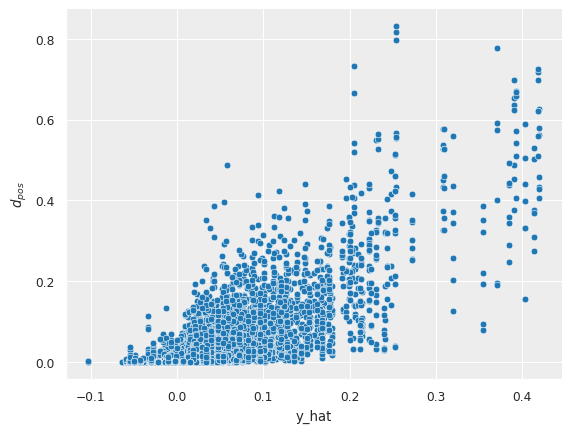

In [96]:
corr_cols = [col for col in aligned_features if col not in aligned_cols]

corr_df = aligned_features[["mean_" + feat] + corr_cols].rename(name_mapping, axis=1)
corr_df = corr_df.sort_values(feat.pretty, ignore_index=True)
print(
    corr_df.select_dtypes("number")
    .corr()
    .loc[feat.pretty]
    .abs()
    .sort_values(ascending=False)[:5]
)
print()
plot_df = aligned_features.rename(name_mapping, axis=1)
reg_mask = (
    plot_df.columns.isin(corr_cols)
    & (~plot_df.isna().any(axis=0))
    & ((plot_df != 0).any(axis=0))
)
y_nan_mask = ~plot_df[feat.pretty].isna()
X = plot_df.loc[y_nan_mask, reg_mask].select_dtypes("number").to_numpy()
Y = plot_df.loc[y_nan_mask, feat.pretty].to_numpy()
# X = (X - X.mean(axis=0)) / X.std(axis=0)
X = np.concatenate([np.ones((len(X), 1)), X], axis=1)
beta = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(Y)
y_hat = X.dot(beta)
plot_df.loc[y_nan_mask, "y_hat"] = y_hat
print(np.corrcoef(y_hat, Y))
sn.scatterplot(plot_df, x="y_hat", y=feat.pretty)
# plot_df.loc[:,[feat.pretty]].corr(plot_df.select_dtypes("number")).abs().sort_values(ascending=False)
# fig = plt.figure(figsize=(10, 4))
# sn.lineplot(plot_df, x="mean_kmer_similarity_10", y=feat.pretty)

In [9]:
result_df = pd.read_pickle(
    "/hits/fast/cme/bodynems/MSA_difficulty/results/treebase/modeling/2025-05-12_19-55-34_crossval.pkl"
)
result_df.sort_values("test_neg_root_mean_squared_error", ascending=False).iloc[:10]

fit_time  \
n_estimators learning_rate max_depth min_samples_leaf max_features loss                        
2000         0.01          8         5                0.1          huber           18.602376   
                                                                   squared_error    7.260840   
             0.02          8         5                0.1          huber           28.880611   
             0.01          8         3                0.1          huber           25.323187   
             0.02          8         5                0.1          absolute_error  29.091998   
                                     3                0.1          absolute_error  32.524707   
                                     9                0.1          huber           21.308341   
             0.01          8         9                0.1          huber           15.612983   
                                     5                0.1          absolute_error  27.710601   
                                                      0.3          absolute_error  29.062024   

                                                                                   score_time  \
n_estimators learning_rate max_depth min_samples_leaf max_features loss                         
2000         0.01          8         5                0.1          huber             0.018389   
                                                                   squared_error     0.024583   
             0.02          8         5                0.1          huber             0.025216   
             0.01          8         3                0.1          huber             0.021207   
             0.02          8         5                0.1          absolute_error    0.027156   
                                     3                0.1          absolute_error    0.027603   
                                     9                0.1          huber             0.022954   
             0.01          8         9                0.1          huber             0.018235   
                                     5                0.1          absolute_error    0.026147   
                                                      0.3          absolute_error    0.021822   

                                                                                    test_r2  \
n_estimators learning_rate max_depth min_samples_leaf max_features loss                       
2000         0.01          8         5                0.1          huber           0.491899   
                                                                   squared_error   0.489038   
             0.02          8         5                0.1          huber           0.489454   
             0.01          8         3                0.1          huber           0.489169   
             0.02          8         5                0.1          absolute_error  0.488308   
                                     3                0.1          absolute_error  0.487800   
                                     9                0.1          huber           0.487129   
             0.01          8         9                0.1          huber           0.485642   
                                     5                0.1          absolute_error  0.485919   
                                                      0.3          absolute_error  0.485631   

                                                                                   test_neg_root_mean_squared_error  \
n_estimators learning_rate max_depth min_samples_leaf max_features loss                                               
2000         0.01          8         5                0.1          huber                                  -0.063784   
                                                                   squared_error                          -0.063924   
             0.02          8         5                0.1          huber                                  -0.063928   
             0.01          8  